# Loop for running bnpstep to fit existing FIONA traces

### Import necessary packages

In [43]:
# All inputs
import importlib
import time
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import tkinter as tk
from tkinter import filedialog
import scipy.io
import os
import bnpstep_ori as bnp_ori
import bnpstep_Fh as bnp_Fh
importlib.reload(bnp_Fh)
import bnpstep as bnp
importlib.reload(bnp)

def insert_before_pattern(fname, insert_str, pattern):
    idx = fname.find(pattern)
    if idx == -1:
        return fname  # return unchanged
    return fname[:idx] + insert_str + fname[idx:]

### Select (multiple) .mat fiona files for loading

In [47]:
file_paths = [r'C:\Users\Yildiz Lab\Desktop\BNP\Stier v2\241113-01-100126_47094_fiona.mat']
n_samples = 1000

### Run through all files and save bnpstep results in .mat and .pkl format

Note: We will read the step number in the trace to give us an estimate of number of steps. It might slightly increase time, but it is necessary to make sure we aren't overloading the matrices. It seems by parameter sweep that 10000 iterations is good to get most of the convergence by eye.

In [48]:
# now run and save all results to load in later for the trace long-axis. (Short-axis to come later)

for i in range(len(file_paths)):
    matdata = scipy.io.loadmat(file_paths[i], squeeze_me=False, struct_as_record=True)
    p = Path(file_paths[i])

    # print(matdata['data'].dtype)
    data_struct = matdata['data'][0, 0]  

    # Write a csv to load data, then immediately delete
    # Remove Nan's they don't need to be there
    data_struct['time'] = data_struct['time'][~np.isnan(data_struct['time'])]
    data_struct['trace'] = data_struct['trace'][~np.isnan(data_struct['trace'][:,0])]
    
    # t_trace_arr = np.array([data_struct['time'].reshape(len(data_struct['time']),1).flatten(), data_struct['trace'][:,0].reshape(len(data_struct['time']),1).flatten()])
    t_trace_arr = np.array(data_struct['trace'][:,0].reshape(len(data_struct['time']),1).flatten())    
    # t_trace_arr = t_trace_arr.reshape(len(data_struct['time']),2)
    t_trace_arr = t_trace_arr.transpose()
    print(t_trace_arr.shape)
    np.savetxt(str(p.parent)+'/'+p.stem+'_tempdata.csv', t_trace_arr, delimiter=',')

    # Initialize the data with the sampler with about twice as many steps as the user found
    A = data_struct['trace'][:,2]
    estimated_steps = np.sum(np.roll(A,1)!=A)
    if estimated_steps > 512/1.7:
        print('skipping', p.stem, 'for too many steps')
    else:
        start_time = time.perf_counter()
        
        sampler = bnp_Fh.BNPStep(B_max=int(2*estimated_steps))
        sampler.load_data(str(p.parent)+'/'+p.stem+'_tempdata.csv', has_timepoints=False)
        print("Sampler initialized with max steps:", int(1.7*estimated_steps), "sampling for", n_samples, "iterations.")
        sampler.analyze(num_samples= n_samples)
        sampler.results_to_file(outfile=str(p.parent)+'/'+p.stem+'_trial_sample')
        
        end_time = time.perf_counter()
        duration = end_time - start_time
        print(f"Iteration took {duration:.6f} seconds for updated method", len(sampler.Wacc))
        
        # Benchmark with the original method
        start_time = time.perf_counter()
        sampler_ori = bnp_ori.BNPStep(B_max=int(2*estimated_steps))
        sampler_ori.load_data(str(p.parent)+'/'+p.stem+'_tempdata.csv', has_timepoints=False)

        print("Sampler_ori initialized with max steps:", int(1.7*estimated_steps), "sampling for", n_samples, "iterations.")
        sampler_ori.analyze(num_samples= n_samples)
        sampler_ori.results_to_file(outfile=str(p.parent)+'/'+p.stem+'_trial_sample_ori')
        # sampler.visualize_results(plot_type='step')        
        end_time = time.perf_counter()
        duration = end_time - start_time
        print(f"Iteration took {duration:.6f} seconds", len(sampler.Wacc))

(1221,)
Sampler initialized with max steps: 45 sampling for 1000 iterations.


C:\Users\Yildiz Lab\Documents\GitHub\bnp-step_Yildiz\bnpsampler.py:345: RuntimeWarning: overflow encountered in exp
  def sample_eta(weak_limit, num_data, data_points, data_times, b_m_vec, h_m_vec, t_m_vec, f_vec,


Iteration took 28.050910 seconds for updated method 1221
Sampler_ori initialized with max steps: 45 sampling for 1000 iterations.


C:\Users\Yildiz Lab\Documents\GitHub\bnp-step_Yildiz\bnpsampler.py:524: RuntimeWarning: divide by zero encountered in log
C:\Users\Yildiz Lab\Documents\GitHub\bnp-step_Yildiz\bnpsampler.py:573: RuntimeWarning: divide by zero encountered in log
C:\Users\Yildiz Lab\Documents\GitHub\bnp-step_Yildiz\bnpsampler.py:579: RuntimeWarning: invalid value encountered in scalar add
C:\Users\Yildiz Lab\Documents\GitHub\bnp-step_Yildiz\bnpsampler.py:345: RuntimeWarning: overflow encountered in exp
  def sample_eta(weak_limit, num_data, data_points, data_times, b_m_vec, h_m_vec, t_m_vec, f_vec,


Iteration took 36.940292 seconds 1221


## Visualization of data with python (Not operational with current setup)

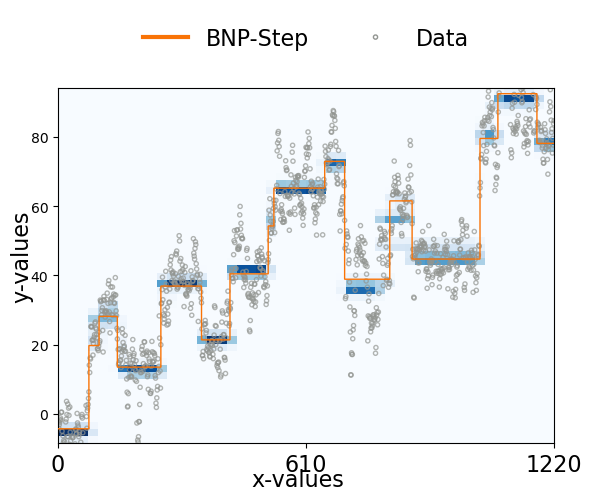

<Figure size 640x480 with 0 Axes>

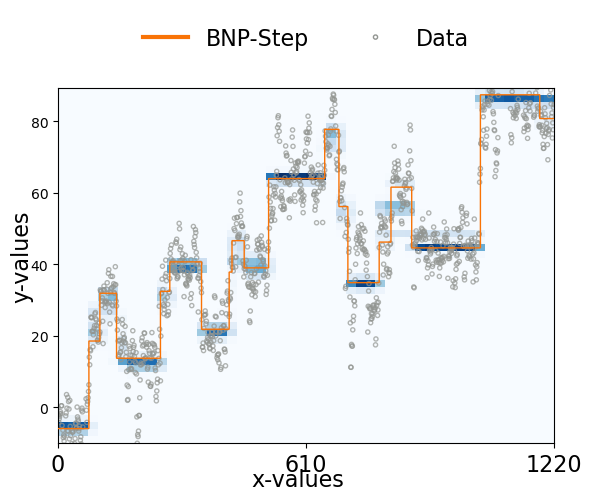

In [49]:
rootdir1 = r'C:\Users\Yildiz Lab\Desktop\BNP\Stier v2\\'
rootdir2 = r'C:\Users\Yildiz Lab\Desktop\BNP\Stier v2\\'
# sampler = bnp.BNPStep(B_max=122)
sampler.load_data(str(p.parent)+'/241113-01-100126_47094_fiona_tempdata.csv', has_timepoints=False)
sampler.results_from_file(filename=rootdir1+'241113-01-100126_47094_fiona_trial_sample')
sampler.visualize_results(plot_type='step')

plt.figure()
sampler_ori.load_data(str(p.parent)+'/241113-01-100126_47094_fiona_tempdata.csv', has_timepoints=False)
sampler_ori.results_from_file(filename=rootdir1+'241113-01-100126_47094_fiona_trial_sample_ori')
sampler_ori.visualize_results(plot_type='step')

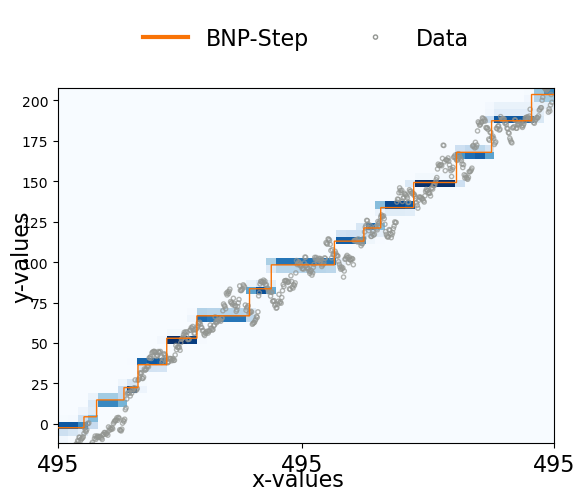

In [17]:
sampler.results_from_file(filename='/Users/slivka/Documents/University of California/Research/2Color/79469_fiona_trial_sample')
sampler.visualize_results(plot_type='step')

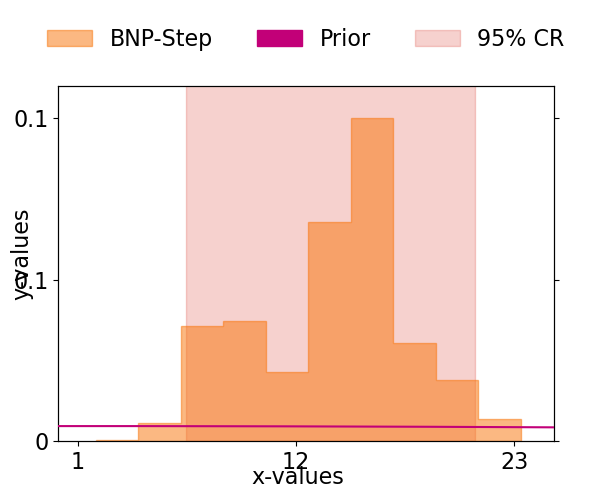

In [18]:
sampler.visualize_results(plot_type='hist_step_height')